In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model import get_npe_model
from experiments.npe_bt.simulate import show_simulation

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [2]:
data = np.load('data/threeboxes_rotations_1.npz', allow_pickle=True)

In [3]:
train_x = []
val_x = []

for i in range((data['config'].item()['num_objects'] - 1) * 2 + 1):
    train_x.append(data['arr_%i' % (i)])
    val_x.append(data['arr_%i' % (i + (data['config'].item()['num_objects'] - 1) * 2 + 1)])
    
train_y = data['train_y']
val_y = data['val_y']

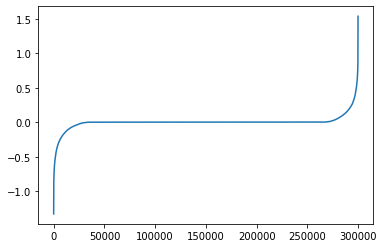

In [5]:
plt.plot(sorted(val_y[:, 2]))

In [64]:
train_x[0][:, 3].max()

0.382026659529361

In [12]:
tf.keras.backend.set_floatx('float64')

model = get_npe_model(max_pairs = 2, state_dim = 6, out_dim = 3, hidden_size = 50)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

def vel_loss(ytrue, ypred):
    return 1e1 * tf.keras.losses.MSE(ytrue[..., :2], ypred[..., :2])

def ang_pi_loss(ytrue, ypred):
    return -tf.math.cos(ytrue[..., 2] * 2 * np.pi - ypred[..., 2] * 2 * np.pi)

def ang_loss(ytrue, ypred):
    return 1e1 / 7.0 * tf.keras.losses.MSE(ytrue[..., 2], ypred[..., 2])
    
def loss(ytrue, ypred):
    return (vel_loss(ytrue, ypred) + ang_loss(ytrue, ypred))


model.compile(loss=loss, metrics=[vel_loss, ang_loss], optimizer=opt)

In [ ]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=30, batch_size=2048, shuffle=True)

In [ ]:
show_simulation(model)

In [72]:
np.set_printoptions(suppress=True)
train_y[:, 2].max()

8.527227498905328e-15

In [81]:
train_x[0][0]

array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.66306668,
        0.91784411, -0.34994342, -0.7536976 ])

In [26]:
p = model(val_x)

In [30]:
plt.plot(sorted(p[:, 0]))

KeyboardInterrupt: 

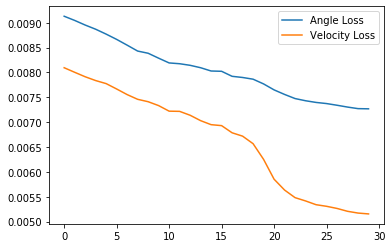

In [60]:
plt.plot(history.history['ang_loss'], label="Angle Loss")
plt.plot(history.history['vel_loss'], label="Velocity Loss")
plt.legend()

In [85]:
from experiments.npe_bt.datagen import collect_data as collect_data_bt
from experiments.npe.datagen import collect_data as collect_data_orig

In [96]:
train_x_orig, train_y_orig = collect_data_orig(
        num_sequences=100,
        sequence_length=60,
        radius=30,
        seed=1337,
    )

100%|██████████| 100/100 [00:00<00:00, 130.59it/s]


In [97]:
train_x_bt, train_y_bt = collect_data_bt(
        num_sequences=100,
        sequence_length=60,
        radius=30,
        seed=1337,
    )

100%|██████████| 100/100 [00:00<00:00, 118.97it/s]


In [98]:
train_x_orig[0]

[array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.66306668,
         0.91784411, -0.34994342, -0.7536976 ]),
 array([0.74882812, 0.70390625, 0.42287457, 0.59242487, 0.78012912,
        0.72550466, 0.57146718, 0.34827979]),
 array([ 0.51328125,  0.75273437, -0.18819043, -0.21944898,  0.4943042 ,
         0.73477623, -0.18819043, -0.21944898]),
 array([1.]),
 array([1.])]

In [99]:
train_x_bt[0]

[array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.        ,
        -0.        ,  0.66306668,  0.91784411, -0.34994342, -0.7536976 ,
        -0.        , -0.        ]),
 array([ 0.74882812,  0.70390625,  0.42287457,  0.59242487,  0.        ,
        -0.        ,  0.78012912,  0.72550466,  0.57146718,  0.34827979,
        -0.        , -0.        ]),
 array([ 0.51328125,  0.75273437, -0.18819043, -0.21944898,  0.        ,
        -0.        ,  0.4943042 ,  0.73477623, -0.18819043, -0.21944898,
        -0.        , -0.        ]),
 array([1.]),
 array([1.])]

In [100]:
train_y_orig[0]

array([0.35546072, 0.31712341])

In [101]:
train_y_bt[0]

array([ 0.35546072,  0.31712341, -0.        ])

In [ ]:
plt.plot()

In [59]:
model.save('model_zoo/block_tower_1.h5')

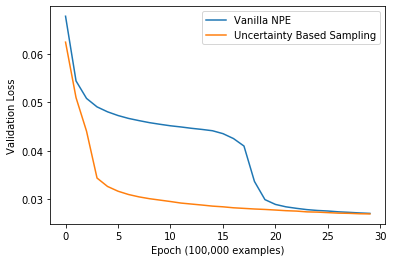

In [21]:
plt.plot(baseline_history.history['loss'], label="Vanilla NPE")
plt.plot(history.history['loss'], label="Uncertainty Based Sampling")
plt.xlabel('Epoch (100,000 examples)')
plt.ylabel('Validation Loss')
plt.legend()

In [36]:
def windowed(series, agg=lambda x: sum(x) / float(len(x)), window=3):
    finals = [] #series[:window]
    
    for i in range(len(series)):
        chunk = series[i:i+window]
        val = agg(chunk)
        finals.append(val)
        
    return np.array(finals)

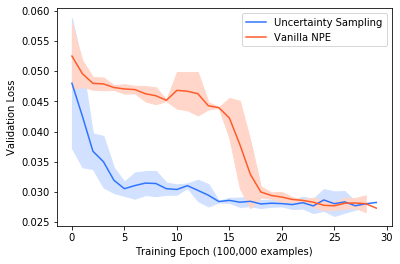

In [42]:
from scipy.stats import sem

smooth_model = windowed(history.history['val_loss'])
sem_model = windowed(history.history['val_loss'], agg=lambda x: sem(x) * 1.9)
plt.fill_between(list(range(len(smooth_model))), smooth_model - sem_model,  
                 smooth_model + sem_model, color="#d1e1ff") 
plt.plot(smooth_model, color="#2e74ff", label="Uncertainty Sampling")

smooth_model = windowed(baseline_history.history['val_loss'])
sem_model = windowed(baseline_history.history['val_loss'], agg=lambda x: sem(x) * 1.9)
plt.fill_between(list(range(len(smooth_model))), smooth_model - sem_model,  
                 smooth_model + sem_model, color="#ffd6c9") 
plt.plot(smooth_model, color="#ff5b29", label="Vanilla NPE")

plt.xlabel('Training Epoch (100,000 examples)')
plt.ylabel('Validation Loss')
plt.legend()

plt.savefig('uncertainty_loss.svg')

In [81]:
from experiments.npe.simulate import show_simulation as sso
from experiments.npe.simulate import show_simulation_variational as ssop

In [52]:
model = tf.keras.models.load_model('model_zoo/npe_replicate_b50_e57.h5')
outputs = sso(model, draw=False, length=30)

/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


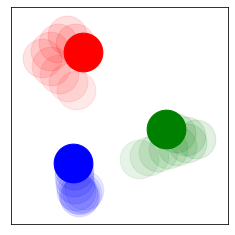

In [80]:
colors = ['red', 'green', 'blue']
s = 1500
f = 0

def plot_circles(positions, t = 0, alpha = 1.0):
    plt.xlim((0, 256))
    plt.ylim((0, 256))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axes().set_aspect('equal')

    for i, pos in enumerate(positions):
        plt.scatter([pos[0] + t*f], [pos[1] + t*f], s = s, c = colors[i], alpha=alpha)

for i, op in enumerate(outputs[:10]):
    plot_circles(op, t = i, alpha = (len(outputs) - i) / (len(outputs) + 200) if i != 0 else 1.0)
    
plt.savefig('npe_dv.svg')

In [100]:
model = tf.keras.models.load_model('model_zoo/stochastic_npe_1.h5')
outputs = ssop(model, draw=False, length=30, rollouts=50)

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


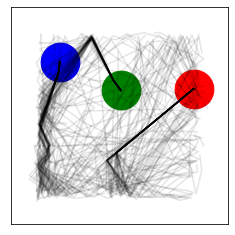

In [101]:
def plot_rollout(rollout):
    """rollout is a list of positions"""
    
    plt.plot(rollout[:, 0], rollout[:, 1], color='black', alpha=0.1)

ops = np.array(outputs)
ro = np.swapaxes(ops, 1, 2)

for sim in ro:
    for c in sim:
        plot_rollout(c)

plot_circles(outputs[0][0])

plt.savefig('pnpe_ro_3.svg')

In [102]:
model.input_shape

[(None, 8), (None, 8), (None, 8), (None, 1), (None, 1)]

In [105]:
d['val']

([[array([0.2796875 , 0.54257813, 0.28866775, 0.5044186 ]),
   array([0.56835938, 0.7171875 , 0.5390625 , 0.74296875]),
   array([0.20546875, 0.62421875, 0.16601975, 0.65730015]),
   array([1.]),
   array([1.])],
  [array([0.27322419, 0.46402814, 0.26271797, 0.44730373]),
   array([0.48046875, 0.79453125, 0.45117188, 0.8203125 ]),
   array([0.12052581, 0.68753436, 0.10056328, 0.69918065]),
   array([1.]),
   array([1.])],
  [array([0.24170553, 0.41385492, 0.23119931, 0.39713051]),
   array([0.39257812, 0.871875  , 0.36328125, 0.89765625]),
   array([0.14010972, 0.72247321, 0.15607975, 0.73411949]),
   array([1.]),
   array([1.])],
  [array([0.21018686, 0.3636817 , 0.19968064, 0.34695729]),
   array([0.35425342, 0.88773978, 0.36900126, 0.87502526]),
   array([0.13845387, 0.71930638, 0.11037918, 0.69709163]),
   array([1.]),
   array([1.])],
  [array([0.1786682 , 0.31350848, 0.16816197, 0.29678407]),
   array([0.39849693, 0.8538476 , 0.41324477, 0.84325877]),
   array([0.15830576, 0.6526

In [157]:
data = np.load('data/threecircles_small_complex.npz', allow_pickle=True)

train_x = []
val_x = []

for i in range((data['config'].item()['num_objects'] - 1) * 2 + 1):
    train_x.append(data['arr_%i' % (i)])
    val_x.append(data['arr_%i' % (i + (data['config'].item()['num_objects'] - 1) * 2 + 1)])
    
train_y = data['train_y']
val_y = data['val_y']
complex_x = data['train_complex']

In [158]:
samples = 1000

xs = np.zeros((len(train_x[0]), samples))
ys = np.zeros((len(train_x[0]), samples))

for s in tqdm.tqdm(range(samples)):
    p = model(train_x)
    
    xs[:, s] = p[:, 0].numpy()
    ys[:, s] = p[:, 1].numpy()

100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


In [159]:
variances = (xs.std(axis=1) + ys.std(axis=1)) / 2

In [178]:
buckets = []
ll = []
ul = []
e = []

for b in range(9):
    buckets.append(variances[complex_x == b].mean())
    e = variances[complex_x == b].std() / 10
    ll.append(variances[complex_x == b].mean() - variances[complex_x == b].std())
    ul.append(variances[complex_x == b].mean() + variances[complex_x == b].std())

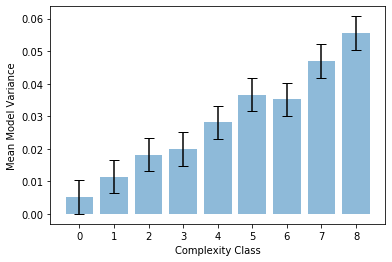

In [184]:
plt.bar(range(len(buckets)), buckets, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.xticks(range(len(buckets)))
plt.xlabel('Complexity Class')
plt.ylabel('Mean Model Variance')
plt.savefig('complexity.svg')

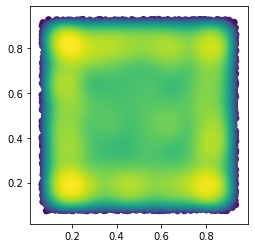

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    
    if ax is None:
        fig , ax = plt.subplots()
        
    ax.set_aspect('equal')
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

px = []
py = []

for t in range(100000):
    # Position
    px.append(train_x[0][t][:2][0])
    py.append(train_x[0][t][:2][1])

    
density_scatter(np.array(px), np.array(py), bins=10)
plt.savefig('density.png')